<a href="https://colab.research.google.com/github/FatmaBuseBorlu/DRAMER-Dataset/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
import kagglehub

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Veri setinin bulunduğu dizin
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"

In [34]:
# RNN Modeli Tanımı
class RNNModel(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, num_classes=2, dropout_rate=0.3):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_valence = nn.Linear(hidden_size, num_classes)
        self.fc_arousal = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # Sadece son zaman adımı
        out = self.dropout(out)
        valence_output = self.fc_valence(out)
        arousal_output = self.fc_arousal(out)
        return valence_output, arousal_output

# Veri Seti Hazırlığı
offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor()
])

dataset = DREAMERDataset(
    io_path='./dreamer_rnn_data',
    mat_path='/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat',  # Veri seti yolunu güncelleyin
    offline_transform=offline_transform,
    label_transform=transforms.Compose([
        transforms.Select(['valence', 'arousal']),
        transforms.Binary(3.0)  # Valence ve Arousal için binary sınıflandırma
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    verbose=False  # Çıktıyı azaltır
)

# Veri Setini Eğitim ve Test Olarak Böl
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Veri Setini Eğitim ve Test Olarak Böl
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


[2024-12-27 07:25:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_rnn_data.


In [35]:
# Veri yükleyiciler
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Veri Setini Eğitim ve Test Olarak Böl
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(input_size=128, hidden_size=256, num_layers=3, num_classes=2, dropout_rate=0.3).to(device)

# Optimizasyon ve Kayıp Fonksiyonları
optimizer = optim.Adam(model.parameters(), lr=0.0005)
valence_criterion = nn.CrossEntropyLoss()
arousal_criterion = nn.CrossEntropyLoss()

# Eğitim Fonksiyonu
def train_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Giriş verisini doğru boyuta dönüştür
        inputs = inputs.float().to(device).squeeze(1)  # [batch_size, seq_len, input_size]
        labels = torch.stack(labels, dim=1).long().to(device)
        optimizer.zero_grad()
        valence_output, arousal_output = model(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = loss_valence + loss_arousal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test_model():
    model.eval()
    running_loss, valence_preds, arousal_preds, all_labels = 0.0, [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Giriş verisini doğru boyuta dönüştür
            inputs = inputs.float().to(device).squeeze(1)  # [batch_size, seq_len, input_size]
            labels = torch.stack(labels, dim=1).long().to(device)
            valence_output, arousal_output = model(inputs)
            loss_valence = valence_criterion(valence_output, labels[:, 0])
            loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
            loss = loss_valence + loss_arousal
            running_loss += loss.item()
            _, valence_pred = torch.max(valence_output, 1)
            _, arousal_pred = torch.max(arousal_output, 1)
            valence_preds.extend(valence_pred.cpu().numpy())
            arousal_preds.extend(arousal_pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    valence_acc = accuracy_score([l[0] for l in all_labels], valence_preds)
    arousal_acc = accuracy_score([l[1] for l in all_labels], arousal_preds)
    valence_f1 = f1_score([l[0] for l in all_labels], valence_preds, average='weighted')
    arousal_f1 = f1_score([l[1] for l in all_labels], arousal_preds, average='weighted')
    return running_loss / len(test_loader), valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds

In [43]:
# Eğitim Döngüsü
epochs = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    train_loss = train_epoch()
    test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, _, _, _ = test_model()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Valence Accuracy: {valence_acc:.4f}, Arousal Accuracy: {arousal_acc:.4f}")
    print(f"Valence F1 Score: {valence_f1:.4f}, Arousal F1 Score: {arousal_f1:.4f}")

Epoch 1/10, Train Loss: 1.1567, Test Loss: 1.0870
Valence Accuracy: 0.6480, Arousal Accuracy: 0.7912
Valence F1 Score: 0.6102, Arousal F1 Score: 0.7459
Epoch 2/10, Train Loss: 1.0481, Test Loss: 1.0168
Valence Accuracy: 0.6707, Arousal Accuracy: 0.8009
Valence F1 Score: 0.6600, Arousal F1 Score: 0.7601
Epoch 3/10, Train Loss: 0.9640, Test Loss: 0.9659
Valence Accuracy: 0.6986, Arousal Accuracy: 0.8147
Valence F1 Score: 0.6938, Arousal F1 Score: 0.7983
Epoch 4/10, Train Loss: 0.8957, Test Loss: 0.9226
Valence Accuracy: 0.7218, Arousal Accuracy: 0.8219
Valence F1 Score: 0.7139, Arousal F1 Score: 0.8042
Epoch 5/10, Train Loss: 0.8370, Test Loss: 0.8875
Valence Accuracy: 0.7359, Arousal Accuracy: 0.8279
Valence F1 Score: 0.7254, Arousal F1 Score: 0.8136
Epoch 6/10, Train Loss: 0.7762, Test Loss: 0.8755
Valence Accuracy: 0.7455, Arousal Accuracy: 0.8378
Valence F1 Score: 0.7361, Arousal F1 Score: 0.8244
Epoch 7/10, Train Loss: 0.7225, Test Loss: 0.8798
Valence Accuracy: 0.7455, Arousal Accu

Final Test Loss: 0.9088
Final Valence Accuracy: 0.7659, Final Arousal Accuracy: 0.8392
Final Valence F1 Score: 0.7605, Final Arousal F1 Score: 0.8314
Confusion Matrix (Valence):
 [[4046 2619]
 [1396 9088]]
Confusion Matrix (Arousal):
 [[ 2175  1846]
 [  912 12216]]


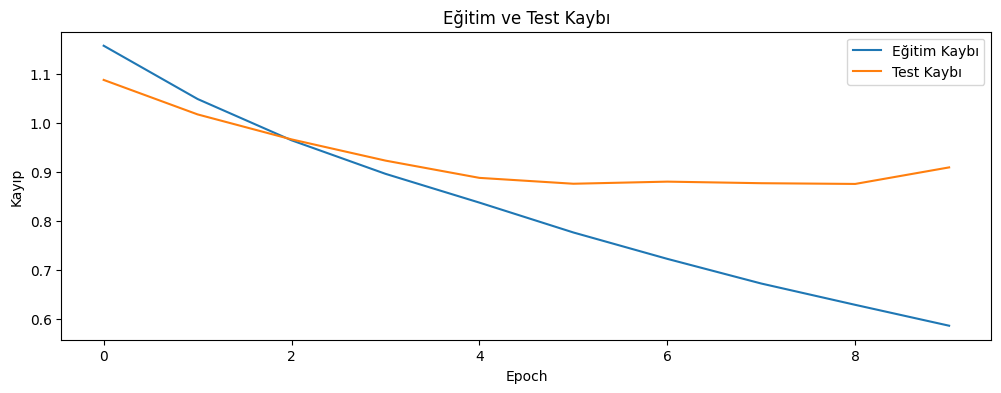

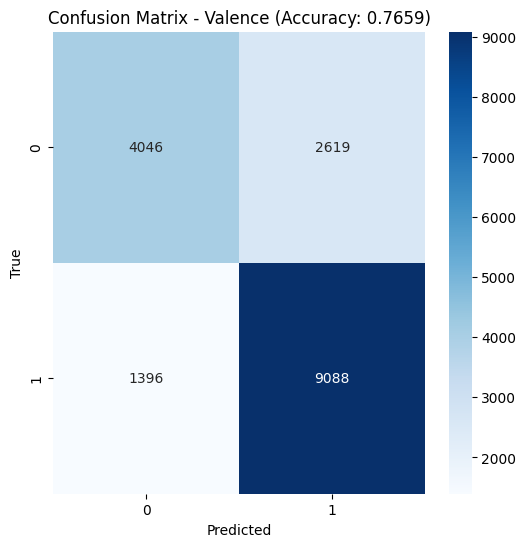

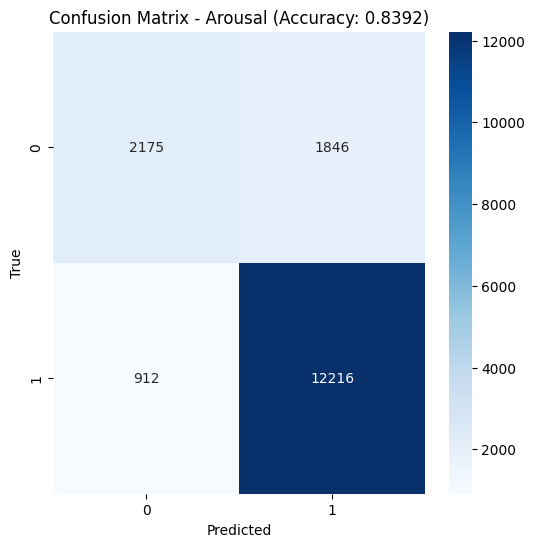

In [44]:
# Sonuçları Test Et ve Raporla
test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds = test_model()
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Valence Accuracy: {valence_acc:.4f}, Final Arousal Accuracy: {arousal_acc:.4f}")
print(f"Final Valence F1 Score: {valence_f1:.4f}, Final Arousal F1 Score: {arousal_f1:.4f}")

# Karışıklık Matrisleri
cm_valence = confusion_matrix([l[0] for l in all_labels], valence_preds)
cm_arousal = confusion_matrix([l[1] for l in all_labels], arousal_preds)
print("Confusion Matrix (Valence):\n", cm_valence)
print("Confusion Matrix (Arousal):\n", cm_arousal)

# Görselleştirme Fonksiyonu
def plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc):
    # Eğitim ve Test Kaybı Grafiği
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    # Valence Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_valence, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Valence (Accuracy: {valence_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Arousal Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_arousal, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Arousal (Accuracy: {arousal_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc)
